In [4]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

info_type = "hidden_states"
layer = "31"
file_name = "rq23_all_settings.csv"

humaneval_file_path = os.path.join(
    "humaneval", "codellama-13b-Instruct", info_type, layer, file_name
)
mbpp_file_path = os.path.join(
    "mbpp", "codellama-13b-Instruct", info_type, layer, file_name
)
code_search_net_java_file_path = os.path.join(
    "code_search_net_java",
    "codellama-13b-Instruct_with_semantic",
    info_type,
    layer,
    file_name,
)
tl_code_sum_file_path = os.path.join(
    "tl_code_sum", "codellama-13b-Instruct_with_semantic", info_type, layer, file_name
)

truthful_qa_file_path = os.path.join("truthful_qa", "llama2_7B_with_semantics", info_type, layer, file_name)
sst2_file_path = os.path.join("sst2", "llama2_7B", info_type, layer, file_name)
advglue_file_path = os.path.join("advglue++", "llama2_7B", info_type, layer, file_name)

from scipy.stats import mannwhitneyu

# Function to calculate p-value
def calculate_p_value(row):
    try:
        # Convert string representation of lists to actual lists
        test_probs = np.array(ast.literal_eval(row['transition_matrix_list'])[1])
        val_probs = np.array(ast.literal_eval(row['transition_matrix_list'])[2])

        # Calculate p_value
        _, p_value = mannwhitneyu(test_probs, val_probs, alternative="two-sided")
        return p_value
    except:
        # Return NaN if conversion fails or if mannwhitneyu cannot be applied
        return np.nan

def get_df(file_path):
    df = pd.read_csv(file_path)
    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    df['PCA_dim'] = pd.to_numeric(df['PCA_dim'], errors='coerce')

    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df["p_value"] = df.apply(calculate_p_value, axis=1)
    if "tl_code_sum" or "code_search_net_java" in file_path:
        df['aucroc'] = df['aucroc'].apply(lambda x: x if x > 0.5 else 1 - x)
    
    return df



In [5]:
def ablation_bar_chart(datasets):
    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 3))

    # Dataset names
    dataset_names = list(datasets.keys())
    
    # Number of datasets
    num_datasets = len(datasets)
    
    # Setting positions for the groups
    pos = np.arange(num_datasets)
    
    # Width of a bar
    bar_width = 0.35

    # Lists to store mean values for DTMC and HMM
    dtmc_means = []
    hmm_means = []

    # Extract mean AUCROC values for DTMC and HMM from each dataset
    for dataset in datasets.values():
        dtmc_mean = dataset.loc['DTMC', 'mean'] if 'DTMC' in dataset.index else 0
        hmm_mean = dataset.loc['HMM', 'mean'] if 'HMM' in dataset.index else 0
        dtmc_means.append(dtmc_mean)
        hmm_means.append(hmm_mean)

    # Plotting the bars for DTMC and HMM
    ax.bar(pos - bar_width/2, dtmc_means, bar_width, label='DTMC', color='#de8390')
    ax.bar(pos + bar_width/2, hmm_means, bar_width, label='HMM', color='#6fabe5')

    # Customizing the plot
    ax.set_ylabel('Mean ROC AUC')
    # ax.set_title('ROC AUC by Model Type Across Datasets')
    ax.set_xticks(pos)
    ax.set_xticklabels(dataset_names)
    ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(0.35, 1.2))

    # Show plot
    plt.tight_layout()
    plt.savefig("plot/ablation_model_type.pdf")
    plt.show()


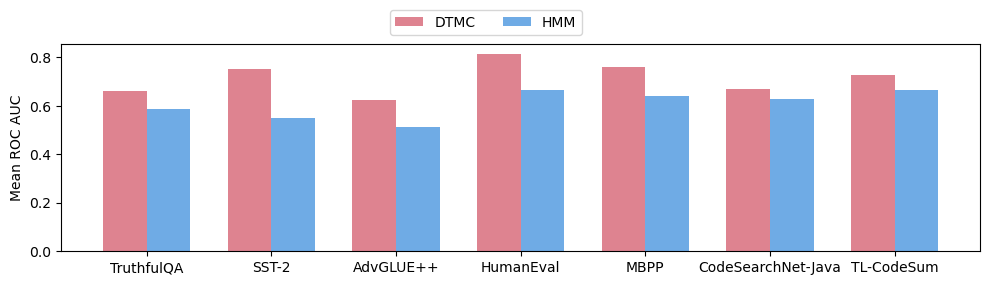

In [6]:
df_humaneval = get_df(humaneval_file_path)
df_mbpp = get_df(mbpp_file_path)
df_code_search_net_java = get_df(code_search_net_java_file_path)
df_tl_code_sum = get_df(tl_code_sum_file_path)

df_truthful_qa = get_df(truthful_qa_file_path)

df_sst2 = get_df(sst2_file_path)
df_advglue = get_df(advglue_file_path)

model_type_truthful_qa_stats = df_truthful_qa.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])
model_type_sst2_stats = df_sst2.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])
model_type_advglue_stats = df_advglue.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])

model_type_humaneval_stats = df_humaneval.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])
model_type_mbpp_stats = df_mbpp.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])
model_type_code_search_net_java_stats = df_code_search_net_java.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])
model_type_tl_code_sum_stats = df_tl_code_sum.groupby('model_type')['aucroc'].agg(['mean', 'max', 'min'])

# Prepare the data
model_type_datasets = {
    "TruthfulQA": model_type_truthful_qa_stats,
    "SST-2": model_type_sst2_stats,
    "AdvGLUE++": model_type_advglue_stats,
    "HumanEval": model_type_humaneval_stats,
    "MBPP": model_type_mbpp_stats,
    "CodeSearchNet-Java": model_type_code_search_net_java_stats,
    "TL-CodeSum": model_type_tl_code_sum_stats
}

ablation_bar_chart(model_type_datasets)
